In [2]:
import os,sys,math
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import importlib
import matplotlib.pyplot as plt
import random
sys.path.append('../hw3') ##直接使用hw3中的model
import image_classification
import image_set
importlib.reload(image_set)
importlib.reload(image_classification)
random.seed(10)


current_dir = os.path.abspath('.')
TRAIN_DIR = os.path.join(current_dir, "../hw3/data/training")
OUTPUT_DIR = os.path.join(current_dir, "output")
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

use_cuda = True & torch.cuda.is_available()
device = torch.device("cuda") if use_cuda else torch.device("cpu")
print("Use cuda." if use_cuda else "Use cpu.")


Use cuda.


In [4]:
#指定模型类别
model_class = image_classification.GYHF_AlexNet
MODEL_PATH =  os.path.join(current_dir, "../hw3/"+str(model_class) + ".pkl")
data = image_set.LearningSet( TRAIN_DIR, model_class.input_size, False)
#使用已经训练好的hw3中的model
model = torch.load(MODEL_PATH)
model = model.to(device)
class_num = data.GetClassNum()

In [6]:
#选出每个类别概率最高的图片
import saliency_map

##先选出概率最高的图片的索引数字
data_loader = torch.utils.data.DataLoader(
    data, 1024, shuffle=False,
    num_workers=2)

#先计算出所有图片的输出
output = np.zeros((1, class_num)) #空矩阵，便于使用concatenate
model.eval()  # 会关闭dropout、batchnorm等
with torch.no_grad():  # 不构建计算图
    for _, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)               
        y_pred = model(images).cpu().numpy()                
        output = np.concatenate((output, y_pred), axis=0)            
output = torch.tensor(output[1:]).float() #去掉第一行的空行
idx = []
for i in range(class_num):
    idx.append(output[:,i].topk(1)[1].item()) #得到所需图片的索引，即为每一类别中概率最大的图片索引号
images,labels = data.GetBatch(idx) #取出这些图片
images, labels = images.to(device), labels.to(device)


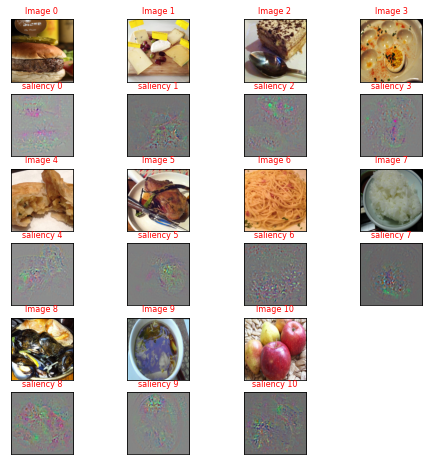

In [8]:
##画出每个类别概率最高的图片的salient map
saliency_map.draw(model, images, labels, image_set.tensor2numpy,8)

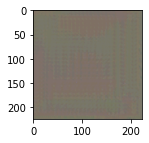

In [10]:
#通过梯度下降来生成能使某个类别的概率最大化的图片
import model_image

image =  model_image.generate(model, device,(3,model.input_size[0],model.input_size[1]), 1, image_set.tensor2numpy,1000, 0.01) 
plt.figure(figsize=(2,2))
plt.imshow(image)     


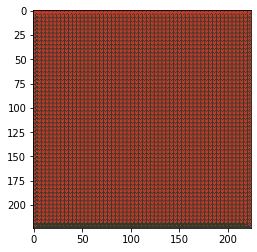

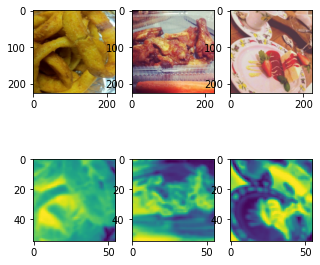

In [13]:
from filter_visualization import g_output,visualization#一定要导入g_output
import importlib
#importlib.reload(filter_visualization)

images,_ = data.GetBatch([1,3,5])
images = images.to(device)
#g_output = None #使用filter_visualization.generate_image前必须声明这个固定名称的全局变量
covd = model.feature_extraction[0] # 这个值需要根据具体的模型结构来指定
filter_id = 0
image,activations  = visualization(images,model, covd, filter_id, (3,model.input_size[0], model.input_size[1]), image_set.tensor2numpy,iters=1000, lr=0.01)

#画出能得到最大激活的图片
plt.figure()
plt.imshow(image)
#画出所有的原图和激活图
fig, axs = plt.subplots(2, len(images), figsize=(5, 5))
for i, img in enumerate(images):
  axs[0][i].imshow(image_set.tensor2numpy(img))
for i, img in enumerate(activations):
  axs[1][i].imshow(img)
plt.show()

In [ ]:
#使用lime来分析model
import lime
import skimage
from lime import lime_image

idx = [1,3,5]
images,labels = data.GetBatch(idx)
model_lime = model.cpu()#lime只能用cpu
#定义lime需要实现的两个函数predict和segmentation
def predict(input):#输入图片，得到预测的类别结果
    #输入的图片格式为numpy,且维度为[batch,w,h,c]
    model_lime.eval()
    #将input转换为pytorch的常用格式[batch,c,w,h]
    input_tensor =torch.FloatTensor(input).permute(0,3,1,2)
    output = model_lime(input_tensor)    
    return output.detach().cpu().numpy()
def segmentation(input):#对输入的图片进行分割100块
    return skimage.segmentation.slic(input, n_segments=100, compactness=1, sigma=1)

fig,axs = plt.subplots(1, len(images))
for i,(image,label) in enumerate(zip(images, labels)):
    x = image.numpy().astype(np.double).transpose(1,2,0) #lime需要输入numpy矩阵
    print(x.shape)
    explainer = lime_image.LimeImageExplainer()
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation) 
    lime_img, mask = explaination.get_image_and_mask(                                                                  label=label.item(), 
        positive_only=False,
        hide_rest=False,
        num_features=class_num,
        min_weight=0.05
    )    
    axs[i].imshow(lime_img)
plt.show()                                                                                                    

In [ ]:
print(labels)